In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

In [5]:
df = pd.read_csv("/content/spam.csv",encoding="latin-1")

df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df = df.dropna(how="any", axis=1)
df.columns = ['target', 'message']

df.head()


,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df["message"][2]


"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

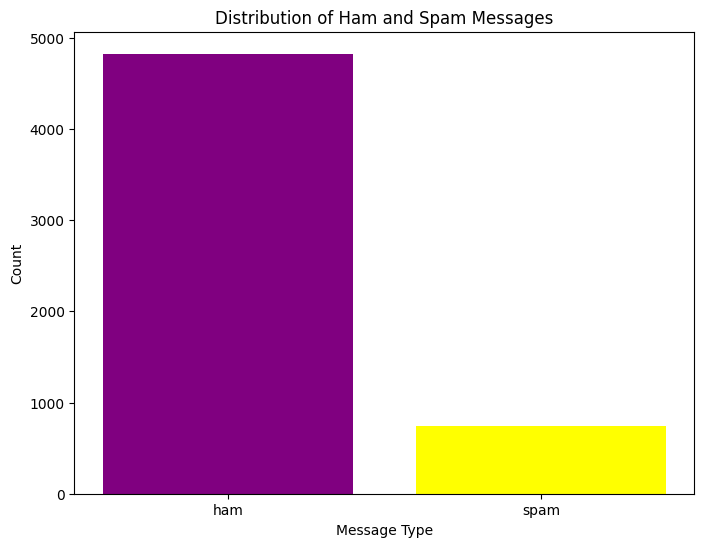

In [8]:
label_counts = df['target'].value_counts()
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=['purple', 'yellow'])
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.title('Distribution of Ham and Spam Messages')
plt.show()

In [9]:
df['length'] = df['message'].apply(lambda x: len(x.split(' ')))
ham_length = df[df['target'] == 'ham']['length']
spam_length = df[df['target'] == 'spam']['length']
print(f'Max length of ham message: {max(ham_length)}')
print(f'Max length of spam message: {max(spam_length)}')

Max length of ham message: 171
Max length of spam message: 35


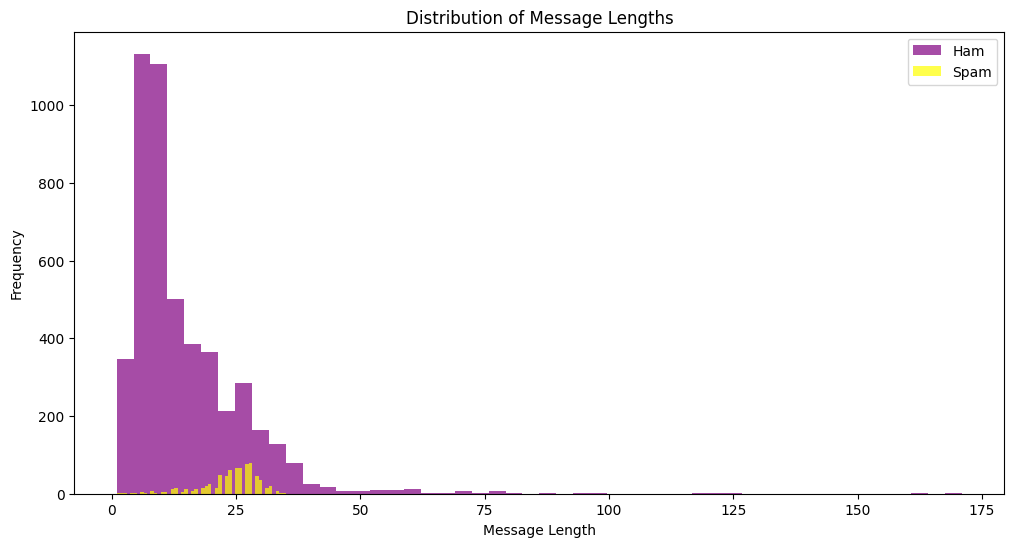

In [10]:
plt.figure(figsize=(12, 6))
plt.hist(ham_length, bins=50, alpha=0.7, label='Ham', color='purple')
plt.hist(spam_length, bins=50, alpha=0.7, label='Spam', color='yellow')
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
# @title TEXT PREPROCESSING



In [12]:
import nltk
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
lemmatizer=WordNetLemmatizer()
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
import re
from nltk.corpus import stopwords
corpus=[]
for i in range(0, len(df)):
  review=re.sub('[^a-zA-Z]'," ",df['message'][i])
  review=review.lower()
  review=review.split()
  review=[lemmatizer.lemmatize(word)for word in review if not word in stopwords.words('english')]
  review=' '.join(review)
  corpus.append(review)
  corpus

In [14]:
# Assuming you have a column named 'message' where you want to remove punctuation first
import string

def remove_punctuation(text):
    no_punc = "".join([char for char in text if char not in string.punctuation])
    return no_punc

df["wo_punc"] = df["message"].apply(lambda text: remove_punctuation(text))

# Now proceed with stop word removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df["wo_stop"] = df["wo_punc"].apply(lambda text: remove_stopwords(text))

In [15]:

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["stemmed_text"] = df["wo_stop"].apply(lambda text: stem_words(text))

df.head()

,target,message,length,wo_punc,wo_stop,stemmed_text
0,ham,"Go until jurong point, crazy.. Available only ...",20,Go until jurong point crazy Available only in ...,Go jurong point crazy Available bugis n great ...,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,Ok lar Joking wif u oni,Ok lar Joking wif u oni,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,Free entry in 2 a wkly comp to win FA Cup fina...,Free entry 2 wkly comp win FA Cup final tkts 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,11,U dun say so early hor U c already then say,U dun say early hor U c already say,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,Nah I dont think he goes to usf he lives aroun...,Nah I dont think goes usf lives around though,nah i dont think goe usf live around though


In [16]:
X = df['stemmed_text']
y = df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4179,) (4179,)
(1393,) (1393,)


In [17]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

vocab_size = len(vectorizer.vocabulary_)
print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 7015


In [18]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

LogisticRegression(max_iter=1000)

In [19]:
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')
f1 = f1_score(y_test, y_pred, pos_label='spam')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)


Accuracy: 0.96
Precision: 0.99
Recall: 0.72
F1 Score: 0.83

Classification Report:
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1207
        spam       0.99      0.72      0.83       186

    accuracy                           0.96      1393
   macro avg       0.98      0.86      0.91      1393
weighted avg       0.96      0.96      0.96      1393


Confusion Matrix:
[[1206    1]
 [  52  134]]


In [20]:
new_message = input("Enter a message: ")
new_message = re.sub('[^a-zA-Z]', ' ', new_message)
new_message = new_message.lower()
new_message = new_message.split()
new_message = [lemmatizer.lemmatize(word) for word in new_message if not word in stopwords.words('english')]
new_message = ' '.join(new_message)
new_message = stem_words(new_message)
new_message_vec = vectorizer.transform([new_message])
prediction = model.predict(new_message_vec)
print("Prediction:", prediction[0])

Enter a message: Go until jurong point, crazy.. Available only ..
Prediction: ham


In [21]:
new_message = input("Enter a message: ")
new_message = re.sub('[^a-zA-Z]', ' ', new_message)
new_message = new_message.lower()
new_message = new_message.split()
new_message = [lemmatizer.lemmatize(word) for word in new_message if not word in stopwords.words('english')]
new_message = ' '.join(new_message)
new_message = stem_words(new_message)
new_message_vec = vectorizer.transform([new_message])
prediction = model.predict(new_message_vec)
print("Prediction:", prediction[0])

Enter a message: Free entry in 2 a wkly comp to win FA Cup fina..
Prediction: spam
